In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot, ks_2samp

In [2]:
train = pd.read_csv("G:/data/Sports-data-analysis/train.csv")
test = pd.read_csv("G:/data/Sports-data-analysis/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [3]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 1


,ID_code
0,train_0
1,train_1


In [4]:
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [5]:
print ('Количиство пропущенных значений в трейне =', train.isnull().sum().sum())

Количиство пропущенных значений в трейне = 0


In [6]:
print ('Количиство пропущенных значений в тесте =', test.isnull().sum().sum())

Количиство пропущенных значений в тесте = 0


Пропущенные значения отсудствуют

In [7]:
train.target.unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='target', ylabel='count'>

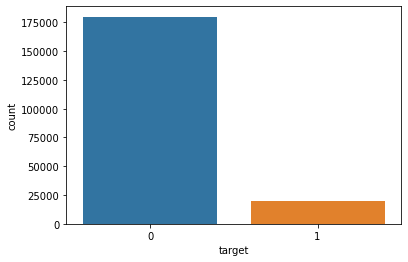

In [8]:
sns.countplot(train['target'])

Целевая переменная имеет 2 класса распределения. Имеется перекос в сторону 0 значения

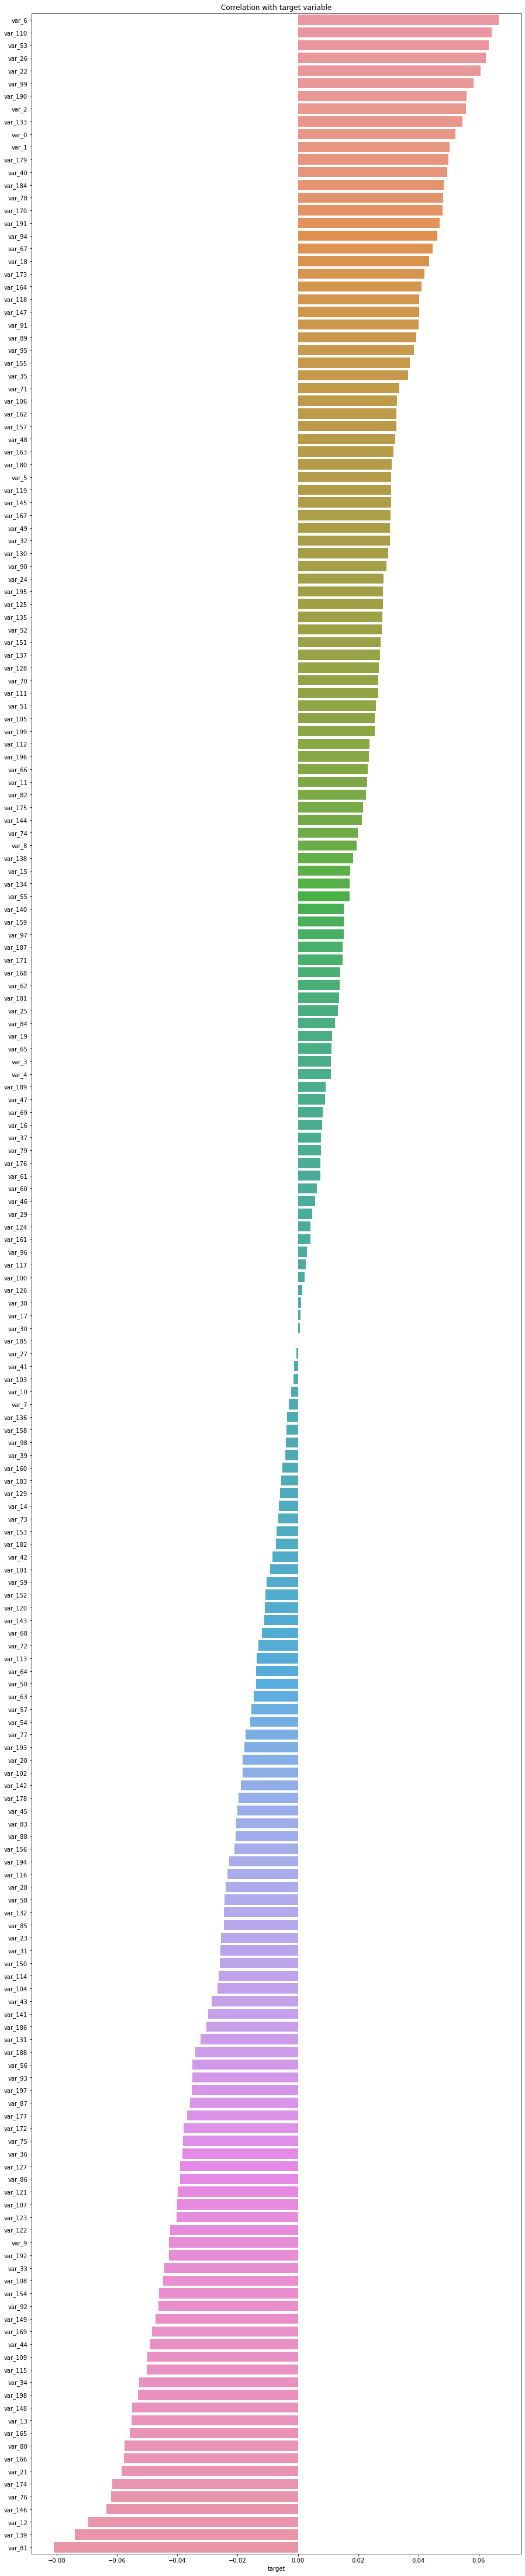

In [9]:
#Кореляция факторов с целевой переменной
cor = train.corr().iloc[1:,0].sort_values(ascending=False)

plt.figure(figsize=(15, cor.shape[0] * 0.4))
sns.barplot(x=cor, y=cor.index)
plt.title('Correlation with target variable')
plt.show();

In [10]:
cor.gt(0).sum()

105

target имеет положительную корреляцию со 105 сущностями

In [11]:
numerical_features = train.select_dtypes(include=[np.number])

Text(0, 0.5, 'Density')

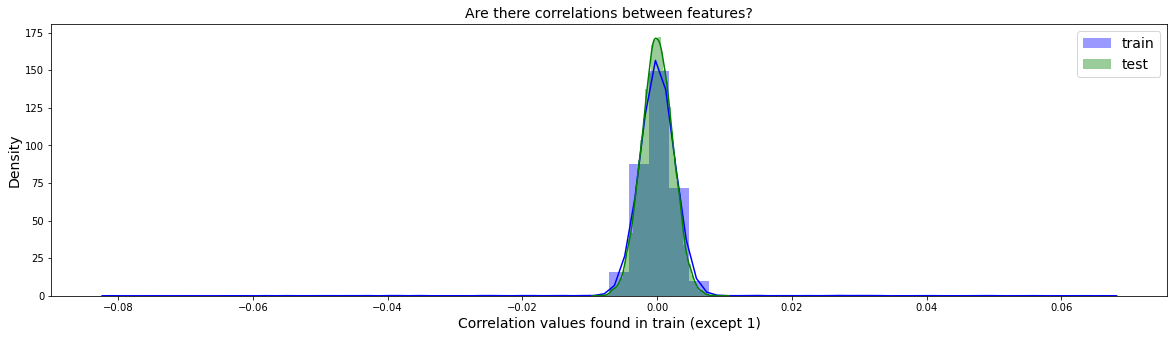

In [12]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Ипризнаки имеют нормальное распределение

In [13]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)[1:11]
corr_with_target

var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
Name: target, dtype: float64

<AxesSubplot:>

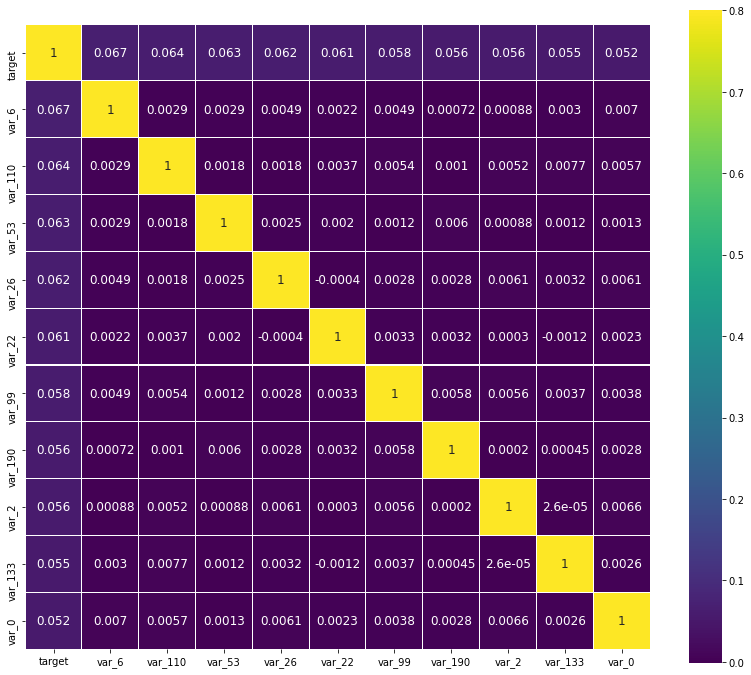

In [14]:
k = 11
cols = correlation.nlargest(k, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

In [15]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

df = train.drop('ID_code', axis=1)


forest = RandomForestRegressor(**parameters)
forest.fit(df.drop(columns= ['target']), df['target'])

Wall time: 2min 56s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

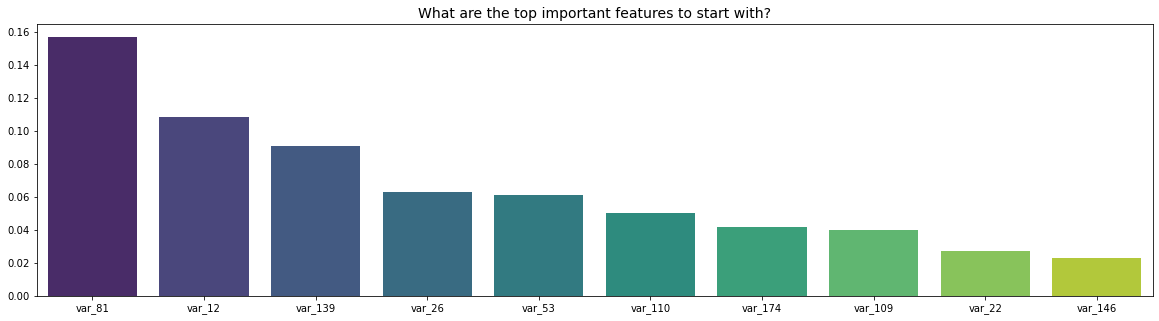

In [16]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

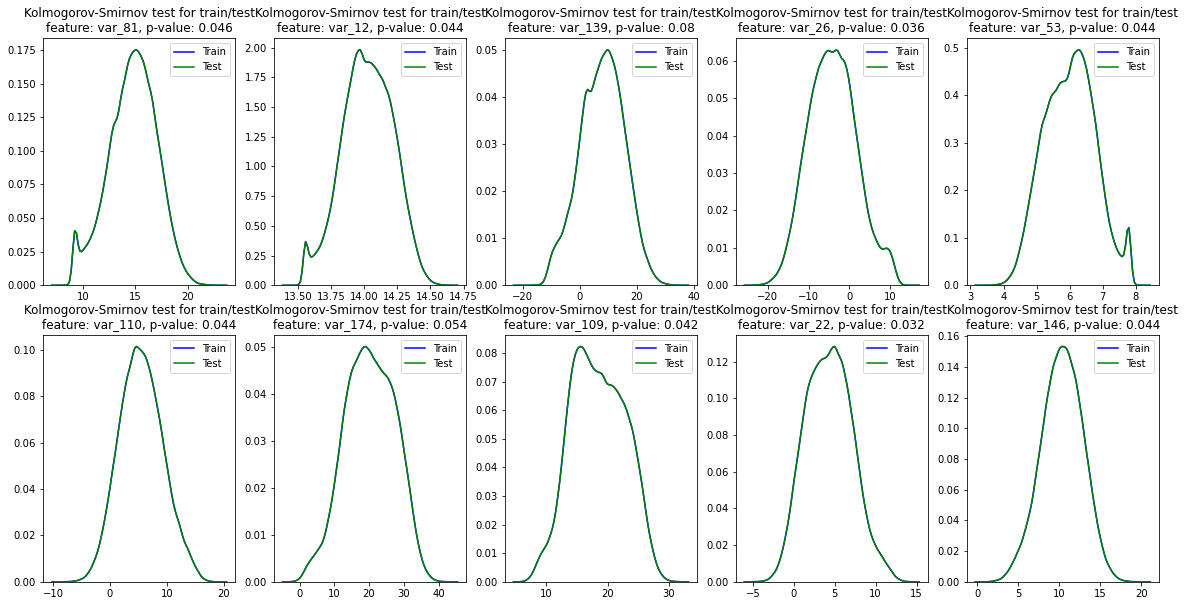

In [17]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

Выводы:

пропуски в жанных отсудствуют

200 непрерывных признаков и 1 номенативный признак "ID_code". 

Все  признаки имеют нормальное распределение,

Можно считать, что линейная связь между признаками отсутствует (p-value  находится примерно у нижней границе 0,05)

target имекет 2 класса, распределен в соотношении 1 к 7  